In [26]:
# Install required libraries, including textstat to replace readability-lxml
!pip install spacy nltk textblob language-tool-python transformers textstat

# Download the spaCy English model
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
import re
import json
from collections import defaultdict

import spacy
from textblob import TextBlob
import language_tool_python
import textstat
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

# Initialize NLP models
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')

def preprocess_text(text):
    """
    Preprocess the SOP text by removing special characters, extra spaces, and converting to lowercase.
    """
    # Remove special characters and digits
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [28]:
!pip install transformers

from transformers import BertTokenizer, BertModel
import torch

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    """
    Generate BERT embeddings for the given text.
    """
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token embedding as the representation of the entire text
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embedding


In [29]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def evaluate_clear_narrative(sop, preprocessed_sop):
    """
    Evaluate the clarity and focus of the narrative by analyzing topic consistency.
    """
    # Split SOP into sentences
    sentences = nltk.sent_tokenize(sop)
    # Vectorize sentences
    vectorizer = CountVectorizer(stop_words='english')
    sentence_vectors = vectorizer.fit_transform(sentences)

    # Apply LDA to identify topics
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(sentence_vectors)
    topic = lda.components_[0]
    # The highest contributing words to the topic
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]

    # Calculate semantic similarity of each sentence to the main topic
    topic_text = ' '.join(top_words)
    topic_embedding = get_bert_embeddings(topic_text)
    narrative_embedding = get_bert_embeddings(preprocessed_sop)

    similarity = cosine_similarity(narrative_embedding, topic_embedding)
    # Higher similarity indicates a more focused narrative
    score = similarity[0][0] * 10
    return round(score, 1)


In [30]:
def evaluate_customization_advanced(sop, program_keywords):
    """
    Evaluate customization by measuring semantic similarity between SOP and program keywords.
    """
    # Join program keywords into a single string
    program_text = ' '.join(program_keywords)

    # Generate embeddings
    sop_embedding = get_bert_embeddings(preprocess_text(sop))
    program_embedding = get_bert_embeddings(preprocess_text(program_text))

    # Calculate cosine similarity
    similarity = cosine_similarity(sop_embedding, program_embedding)
    score = similarity[0][0] * 10
    return round(score, 1)

In [31]:
def evaluate_specificity(sop):
    """
    Evaluate specificity by counting named entities as proxies for detailed examples.
    """
    doc = nlp(sop)
    num_entities = len(doc.ents)
    num_sentences = len(list(doc.sents))
    # More entities per sentence indicate higher specificity
    ratio = num_entities / num_sentences if num_sentences else 0
    score = min(ratio * 10, 10)
    return round(score, 1)


In [32]:
def evaluate_structure(sop):
    """
    Evaluate structure by identifying distinct sections and logical flow.
    """
    intro_keywords = [
    'introduction', 'i am', 'i wish', 'my name is', 'purpose of my application',
    'beginning my career', 'intending to', 'applying for', 'motivated to pursue',
    'interested in', 'my journey', 'starting my academic career', 'aspire to',
    'my background', 'introduction to', 'opening statement', 'goal of', 'aim to',
    'seeking admission', 'desire to', 'reason for applying', 'background in',
    'my experience', 'commenced my studies', 'foundation of my', 'initial interest',
    'starting point', 'intended to', 'my objective', 'aiming to', 'planning to',
    'eager to', 'committed to', 'prepared to', 'ready to', 'keen on', 'excited to',
    'looking forward to', 'interested in pursuing', 'desire to engage', 'aspiring to',
    'motivated by', 'fascinated by', 'passionate about', 'drawn to'
]
    conclusion_keywords = [
    'thank you', 'looking forward', 'in conclusion', 'finally', 'to summarize',
    'in summary', 'to conclude', 'in closing', 'ultimately', 'as a final point',
    'in essence', 'in the end', 'to wrap up', 'in brief', 'to finalize',
    'overall', 'all in all', 'in the final analysis', 'to summarize my points',
    'to end with', 'to finish', 'to close', 'with gratitude', 'appreciate your consideration',
    'appreciate your time', 'thank you for your consideration', 'thank you for your time',
    'appreciate your attention', 'grateful for your consideration', 'thank you for reviewing',
    'hope to hear from you', 'anticipating your response', 'awaiting your decision',
    'eager to join', 'excited about the opportunity', 'hope to contribute', 'looking forward to contributing',
    'enthusiastic about the possibility', 'keen to collaborate', 'ready to embark', 'prepared to engage',
    'anticipate a positive response', 'hope to advance', 'aim to excel', 'strive to succeed',
    'commit to excellence', 'dedicated to my goals', 'ready to pursue', 'motivated to excel',
    'prepared to contribute', 'eager to advance', 'hope to grow', 'look forward to the challenge'
]

    intro = any(kw in sop.lower() for kw in intro_keywords)
    conclusion = any(kw in sop.lower() for kw in conclusion_keywords)

    score = 0
    if intro:
        score += 5
    if conclusion:
        score += 5
    return min(score, 10)


In [33]:
def evaluate_authenticity(sop):
    """
    Evaluate authenticity using sentiment analysis subjectivity.
    """
    blob = TextBlob(sop)
    subjectivity = blob.sentiment.subjectivity  # Range [0,1]
    score = subjectivity * 10
    return round(score, 1)


In [34]:
def evaluate_fit(sop, program_keywords):
    """
    Evaluate fit by measuring semantic similarity and alignment with program keywords.
    """
    # Similar to customization
    return evaluate_customization_advanced(sop, program_keywords)

In [35]:
def evaluate_grammar(sop):
    """
    Evaluate grammar by counting errors identified by LanguageTool.
    """
    matches = tool.check(sop)
    num_errors = len(matches)
    sop_length = len(sop)
    error_rate = num_errors / sop_length if sop_length else 0
    score = max(1, 10 - (error_rate * 100))  # Simplistic scaling
    return round(score, 1)

In [36]:
def evaluate_balanced_content(sop):
    """
    Assess balance between personal anecdotes and academic/professional achievements.
    """
    personal_pronouns = ['i ', 'my ', 'me ', 'mine ', 'myself ']
    personal_count = sum(sop.lower().count(pron) for pron in personal_pronouns)

    technical_keywords = ['mechanical', 'engineering', 'research', 'project', 'thesis', 'development', 'design', 'analysis']
    technical_count = sum(sop.lower().count(kw) for kw in technical_keywords)

    if technical_count == 0:
        score = 5
    else:
        ratio = personal_count / technical_count
        # Ideal ratio is around 1 for balance
        score = max(1, min(10, 10 - abs(ratio - 1) * 10))
    return round(score, 1)

In [37]:
def evaluate_clarity_of_goals(sop):
    """
    Assess clarity of short-term and long-term goals.
    """
    short_term_keywords = ['immediately', 'short-term', 'in the near future', 'next step', 'upcoming']
    long_term_keywords = ['long-term', 'ultimately', 'future', 'career', 'over the years', 'eventually']

    sop_lower = sop.lower()
    short_term = any(kw in sop_lower for kw in short_term_keywords)
    long_term = any(kw in sop_lower for kw in long_term_keywords)

    score = 0
    if short_term:
        score += 5
    if long_term:
        score += 5
    return min(score, 10)


In [38]:
def evaluate_skills(sop, skills_list):
    """
    Evaluate relevant skills using semantic similarity.
    """
    skills_text = ' '.join(skills_list)
    sop_embedding = get_bert_embeddings(preprocess_text(sop))
    skills_embedding = get_bert_embeddings(preprocess_text(skills_text))

    similarity = cosine_similarity(sop_embedding, skills_embedding)
    score = similarity[0][0] * 10
    return round(score, 1)


In [39]:
def evaluate_personal_attributes_advanced(sop, attributes_list):
    """
    Evaluate personal attributes using semantic similarity.
    """
    attributes_text = ' '.join(attributes_list)
    sop_embedding = get_bert_embeddings(preprocess_text(sop))
    attributes_embedding = get_bert_embeddings(preprocess_text(attributes_text))

    similarity = cosine_similarity(sop_embedding, attributes_embedding)
    score = similarity[0][0] * 10
    return round(score, 1)


In [40]:
def evaluate_professionalism(sop):
    """
    Assess professionalism using sentiment analysis and keyword presence.
    """
    professionalism_keywords = ['prepared', 'ready', 'commitment', 'dedication', 'professional',
                                'preparedness', 'prepared to', 'ready to', 'committed to', 'dedicated to',
                                'prepared for', 'ready for', 'commitment to', 'dedicated for']
    matches = sum(1 for kw in professionalism_keywords if kw in sop.lower())
    score = min(matches * 2, 10)  # Each keyword adds 2 points
    return round(score, 1)


In [41]:
def evaluate_usp(sop, usp_phrases):
    """
    Identify unique selling propositions using semantic similarity.
    """
    usp_text = ' '.join(usp_phrases)
    sop_embedding = get_bert_embeddings(preprocess_text(sop))
    usp_embedding = get_bert_embeddings(preprocess_text(usp_text))

    similarity = cosine_similarity(sop_embedding, usp_embedding)
    score = similarity[0][0] * 10
    return round(score, 1)


In [42]:
def evaluate_formatting(sop):
    """
    Evaluate adherence to formatting by checking paragraph structure.
    """
    paragraphs = sop.strip().split('\n\n')
    if len(paragraphs) < 3:
        return 4  # Not enough paragraphs
    else:
        return 10  # Assuming good formatting


In [43]:
def evaluate_pitfalls(sop, clichés_list):
    """
    Assess the presence of clichés and deduct points accordingly.
    """
    matches = sum(1 for c in clichés_list if c in sop.lower())
    score = max(1, 10 - (matches * 2))
    return round(score, 1)


In [44]:
def evaluate_consistency(sop, resume_text=None, recommendation_letters=None):
    """
    Placeholder for evaluating consistency with other application materials.
    """
    # Implement consistency checks here by comparing key information
    return 5  # Neutral score


In [45]:
def evaluate_professional_language(sop):
    """
    Assess the use of professional and precise language by analyzing word complexity.
    """
    words = sop.split()
    total_words = len(words)
    complex_words = [word for word in words if len(word) > 7]
    ratio = len(complex_words) / total_words if total_words else 0
    score = ratio * 10  # Higher ratio implies more professional language
    score = min(max(score, 1), 10)
    return round(score, 1)


In [46]:
def evaluate_positive_tone(sop):
    """
    Assess the positivity of the SOP using sentiment analysis.
    """
    blob = TextBlob(sop)
    polarity = blob.sentiment.polarity  # Range [-1,1]
    score = (polarity + 1) / 2 * 10  # Normalize to [0,10]
    return round(score, 1)


In [47]:
def evaluate_readability_score(sop):
    """
    Assess readability using textstat's Flesch Reading Ease score.
    """
    flesch = textstat.flesch_reading_ease(sop)
    # Map Flesch score to 1-10 scale
    if flesch >= 90:
        score = 10
    elif flesch >= 80:
        score = 9
    elif flesch >= 70:
        score = 8
    elif flesch >= 60:
        score = 7
    elif flesch >= 50:
        score = 6
    elif flesch >= 40:
        score = 5
    elif flesch >= 30:
        score = 4
    elif flesch >= 20:
        score = 3
    else:
        score = 2
    return score


In [48]:
def evaluate_sop_advanced(sop, program_keywords, skills_list, attributes_list, usp_phrases, clichés_list):
    """
    Evaluate the SOP across all criteria using advanced NLP techniques.
    """
    # Preprocess SOP
    preprocessed_sop = preprocess_text(sop)

    # Evaluate each criterion
    scores = {}
    scores["Clear and Focused Narrative"] = evaluate_clear_narrative(sop, preprocessed_sop)
    scores["Customization to the Specific Program or Institution"] = evaluate_customization_advanced(sop, program_keywords)
    scores["Specificity and Detail with Concrete Examples"] = evaluate_specificity(sop)
    scores["Strong Structure and Organization"] = evaluate_structure(sop)
    scores["Authenticity and Personality"] = evaluate_authenticity(sop)
    scores["Demonstrated Fit with the Program/Institution"] = evaluate_fit(sop, program_keywords)
    scores["Error-Free Writing (Grammar, Spelling, Punctuation)"] = evaluate_grammar(sop)
    scores["Balanced Content (Personal Anecdotes vs. Academic/Professional Achievements)"] = evaluate_balanced_content(sop)
    scores["Clarity of Goals (Short-term and Long-term)"] = evaluate_clarity_of_goals(sop)
    scores["Relevant Skills and Qualifications"] = evaluate_skills(sop, skills_list)
    scores["Personal Attributes (e.g., Resilience, Adaptability)"] = evaluate_personal_attributes_advanced(sop, attributes_list)
    scores["Professionalism and Preparedness"] = evaluate_professionalism(sop)
    scores["Unique Selling Proposition (USP)"] = evaluate_usp(sop, usp_phrases)
    scores["Adherence to Formatting Guidelines"] = evaluate_formatting(sop)
    scores["Avoidance of Common Pitfalls (e.g., Clichés, Irrelevant Information)"] = evaluate_pitfalls(sop, clichés_list)
    scores["Consistency with Other Application Materials"] = evaluate_consistency(sop)  # Placeholder
    scores["Use of Professional Language"] = evaluate_professional_language(sop)
    scores["Positive Tone and Constructive Framing"] = evaluate_positive_tone(sop)
    scores["Readability"] = evaluate_readability_score(sop)

    return scores


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_scores(scores):
    """
    Visualize the SOP evaluation scores using a horizontal bar chart.
    """
    criteria = list(scores.keys())
    values = list(scores.values())

    plt.figure(figsize=(12, 10))
    sns.barplot(x=values, y=criteria, palette='viridis')
    plt.xlabel('Scores')
    plt.title('Advanced SOP Evaluation Scores')
    plt.xlim(0,10)
    plt.show()


<ipython-input-49-8a89ab3ab0e9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=criteria, palette='viridis')


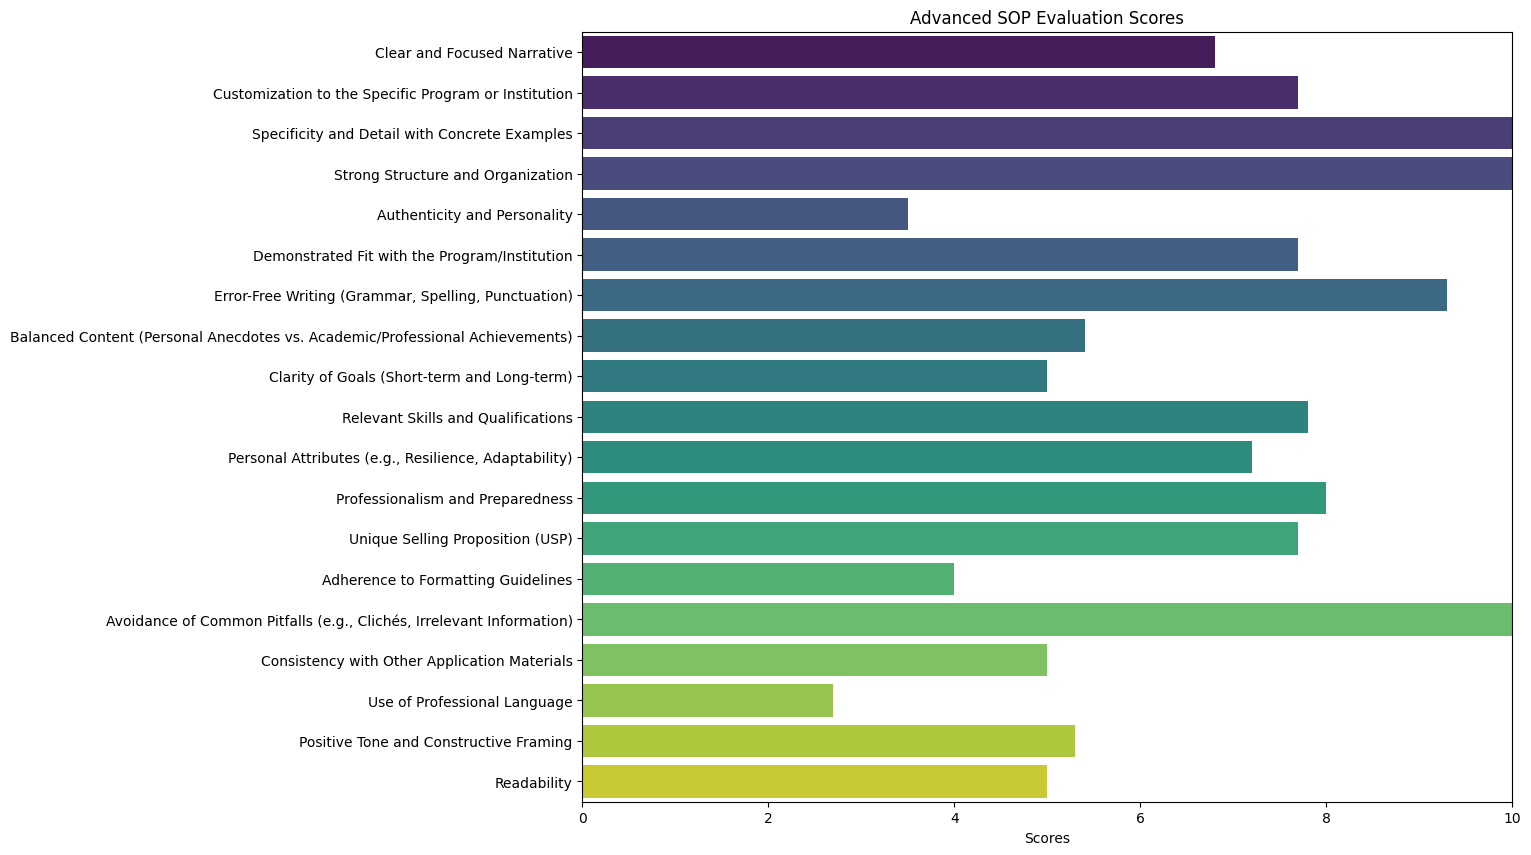

Advanced SOP Evaluation Scores:
Clear and Focused Narrative: 6.8/10
Customization to the Specific Program or Institution: 7.7/10
Specificity and Detail with Concrete Examples: 10/10
Strong Structure and Organization: 10/10
Authenticity and Personality: 3.5/10
Demonstrated Fit with the Program/Institution: 7.7/10
Error-Free Writing (Grammar, Spelling, Punctuation): 9.3/10
Balanced Content (Personal Anecdotes vs. Academic/Professional Achievements): 5.4/10
Clarity of Goals (Short-term and Long-term): 5/10
Relevant Skills and Qualifications: 7.8/10
Personal Attributes (e.g., Resilience, Adaptability): 7.2/10
Professionalism and Preparedness: 8/10
Unique Selling Proposition (USP): 7.7/10
Adherence to Formatting Guidelines: 4/10
Avoidance of Common Pitfalls (e.g., Clichés, Irrelevant Information): 10/10
Consistency with Other Application Materials: 5/10
Use of Professional Language: 2.7/10
Positive Tone and Constructive Framing: 5.3/10
Readability: 5/10


In [50]:
# Define your SOP
sop_text = """
I am Ahmed Rabie Abdelaziz Abdelbaki, teaching assistant at the Mechanical Design and Production department (MDP) at the Faculty of Engineering – Cairo University (FECU) (Solid Mechanics Discipline). I wish to pursue a PhD degree in Mechanical Engineering with an emphasis in Solid Mechanics from a reputable university to fulfill the teaching, research, and consultation responsibilities of my future career. Also to do valuable scientific research that would contribute to the engineering science, and transfer the knowledge gained to engineers, researchers, students, and technicians in my home university.
I have started my engineering study since 2006 when I finished the high school with "Excellent" grades (100.2% - GPA 4). I was the first among the students of my governorate and the twelfth among all the students of the republic. In the FECU, I have studied Mechanical Design Engineering for four years after I finished the preparatory year. I came as the first among all the students of the department in all years and I graduated in June 2011 with grade of "Distinction with honor degree" (Cumulative GPA 3.877). After that I finished my military service in June 2013 and then I was appointed as a demonstrator at the FECU. I have finished the pre-master courses at the MDP Department with cumulative GPA 3.9. Currently I am preparing a master's thesis entitled "Development of a New Dynamic Hydraulic Accumulator" under the supervision of Dr. Chahinaz A. R. Saleh, Associate Professor of Solid Mechanics in the MDP Department at FECU and it's expected to be finished in March 2015. Therefore, I will be ready to enroll for the Ph.D. program starting on the fall of 2015.
My master's thesis is a part of an STDF (Science and Technology Development Fund) granted project to develop a new hydraulic pump and a new servo valve. The project PI: Dr. Mohamed A. Elgamil, Associate Professor of Systems Dynamics in the MDP Department at FECU (Sept. 2012 –2015). I’m working on two papers concerning my work. One of them is going to be published in the 14th Scandinavian International Conference on Fluid Power at Tampere University of Technology. The paper entitled "Second Order Dynamic Accumulators, the features, the applications, and the feasibility" ID141, May 2015. Also a draft is prepared for the second paper to be published in a Journal, expected in May 2015.
During my undergraduate study, I realized my interest in all the topics related to the materials behavior and solid mechanics. Courses such as Stress Analysis, Solid Mechanics, Finite Elements, and Failure Analysis were my preferable; also the courses related to Materials Science such as Strength of Materials, Material Science, Metal Cutting, Casting, Forming and Welding. I travelled to Germany in July 2010 and worked as a research assistant in the Materials Science and Technology department at TU-Clausthal (IAESTE internship). I got great experience in using the laboratory instruments and test rigs. When I came back I worked on my graduation project. It was about "Design and Implementation of a 3D Router CNC Machine". Our group built the machine and tested it and we got an "A" grade in June 2011.
During my work as a teaching and research assistant at the FECU, I have conducted tutorial and laboratory sessions to undergraduate courses such as Stress Analysis, Structural Mechanics, Finite Elements Analysis, Failure Analysis, Engineering Installations of Electromechanical Equipment, Mechanism Synthesis, and Fluid Power Systems.

I hope to find a PhD fellowship and work in a laboratory under supervision of distinguished professors at prestigious University. I am interested in the area of Solid Mechanics and Materials Science. I wish to have the opportunity to work in experimental and computational solid mechanics, multi-scale modeling, finite elements method and applications, and mechanical properties characterization of composite materials. I have the flexibility to work in a multidisciplinary point as I am doing in my master's thesis. I have experience in a number of software programs such as MATLAB, 2D and 3D Modeling (AutoCAD 2D- Solid works), and Finite Elements Analysis (ANSYS, COSMOS Motion, Abaqus CAE), as well as some experience with programming languages such as Visual Basic, Turbo Pascal and FORTRAN.
I know that the opportunities in top universities are very limited so the competition between the PhD students is very high. I have passed the IELTS exam with "7" overall grade and the GRE test with "160" Quantitative grade. I also know that working in a research laboratory is very hard and challengeable but I think I am suitable for a position like that as I am more productive when working under stress.
Finally, I would like to thank you for considering my request to join your University. I’ll be looking forward to receiving your reply.
Ahmed Rabie Abdelbaki
"""

# Define program-specific keywords
# Expanded list of program-specific keywords (approx. 150 keywords)
program_keywords = [
    'solid mechanics', 'mechanical engineering', 'finite elements', 'computational modeling',
    'experimental mechanics', 'composite materials', 'multi-scale modeling', 'finite elements method',
    'mechanical properties', 'stress analysis', 'structural analysis', 'dynamic analysis',
    'material characterization', 'thermodynamics', 'fluid mechanics', 'materials science',
    'strain measurement', 'deformation', 'load analysis', 'structural integrity', 'vibration analysis',
    'nonlinear dynamics', 'simulation', 'CAD modeling', 'FEA', 'ANSYS', 'Abaqus', 'SolidWorks',
    'thermo-mechanical analysis', 'crack propagation', 'material fatigue', 'failure analysis',
    'plastic deformation', 'elasticity', 'yield strength', 'tensile testing', 'compressive testing',
    'shear testing', 'torsion testing', 'biomechanics', 'nanomechanics', 'strain rate', 'stress-strain curve',
    'fracture mechanics', 'finite volume method', 'boundary element method', 'mesh generation',
    'computational fluid dynamics', 'CFD', 'material modeling', 'viscoelasticity', 'thermal expansion',
    'heat transfer', 'energy absorption', 'impact resistance', 'material synthesis', 'material processing',
    'additive manufacturing', '3D printing', 'laser sintering', 'electron beam melting', 'casting',
    'forging', 'welding', 'machining', 'manufacturing processes', 'design optimization',
    'structural optimization', 'topology optimization', 'materials selection', 'lattice structures',
    'composite design', 'hybrid materials', 'metallurgy', 'ceramics', 'polymers', 'biomaterials',
    'materials testing', 'X-ray diffraction', 'scanning electron microscopy', 'transmission electron microscopy',
    'optical microscopy', 'microstructural analysis', 'fractography', 'spectroscopy', 'mechanical testing',
    'strain gauges', 'digital image correlation', 'displacement measurement', 'structural health monitoring',
    'damage detection', 'sensor integration', 'machine learning in mechanics', 'data-driven modeling',
    'artificial intelligence', 'optimization algorithms', 'numerical methods', 'probabilistic modeling',
    'uncertainty quantification', 'computational efficiency', 'parallel computing', 'high-performance computing',
    'model validation', 'experimental validation', 'model calibration', 'parameter estimation',
    'simulation-based design', 'virtual prototyping', 'finite element analysis', 'boundary conditions',
    'initial conditions', 'load cases', 'modal analysis', 'linear elasticity', 'plasticity',
    'viscoplasticity', 'crystal plasticity', 'homogenization', 'multiphysics simulation',
    'thermomechanical coupling', 'structural dynamics', 'buckling analysis', 'crack initiation',
    'crack growth', 'damage mechanics', 'fatigue life prediction', 'material degradation', 'wear analysis',
    'corrosion modeling', 'environmental effects', 'thermal fatigue', 'mechanical fatigue', 'high-temperature materials',
    'low-temperature materials', 'cryogenic engineering', 'pressure vessel analysis', 'pipeline integrity',
    'aerospace materials', 'automotive materials', 'energy materials', 'renewable energy materials',
    'sustainable materials', 'biocompatible materials', 'smart materials', 'shape memory alloys',
    'piezoelectric materials', 'magnetostrictive materials', 'electroactive polymers', 'nanocomposites',
    'graphene', 'carbon nanotubes', 'metal matrix composites', 'polymer matrix composites',
    'fiber-reinforced composites', 'matrix degradation', 'interface mechanics', 'interfacial bonding',
    'mechanical anisotropy', 'elastic modulus', 'shear modulus', 'bulk modulus', 'Poisson\'s ratio',
    'toughness', 'ductility', 'hardness', 'fracture toughness', 'impact toughness', 'residual stress',
    'thermal stresses', 'mechanical stresses', 'stress concentration', 'strain energy density',
    'buckling load', 'critical stress', 'dynamic loading', 'static loading', 'strain localization',
    'stress relaxation', 'creep behavior', 'fatigue crack growth', 'fracture toughness testing'
]


# Define skills list
# Expanded list of skills and software keywords (approx. 100 keywords)
skills_list = [
    'MATLAB', 'AutoCAD', 'SolidWorks', 'ANSYS', 'COSMOS Motion', 'Abaqus CAE', 'Python',
    'C++', 'Simulink', 'LabVIEW', 'Visual Basic', 'Turbo Pascal', 'FORTRAN', 'CAD', 'FEA',
    'Computational Fluid Dynamics', 'CFD', 'Finite Volume Method', 'Boundary Element Method',
    'Mesh Generation', '3D Modeling', 'Design Optimization', 'Structural Optimization',
    'Topology Optimization', 'Materials Selection', 'Additive Manufacturing', '3D Printing',
    'Laser Sintering', 'Electron Beam Melting', 'Casting', 'Forging', 'Welding', 'Machining',
    'Thermo-Mechanical Analysis', 'Vibration Analysis', 'Dynamic Analysis', 'Stress Analysis',
    'Structural Analysis', 'Finite Elements Method', 'Thermodynamics', 'Heat Transfer',
    'Material Characterization', 'X-ray Diffraction', 'Scanning Electron Microscopy',
    'Transmission Electron Microscopy', 'Optical Microscopy', 'Digital Image Correlation',
    'Displacement Measurement', 'Strain Measurement', 'Fatigue Testing', 'Impact Testing',
    'Compression Testing', 'Tensile Testing', 'Shear Testing', 'Torsion Testing',
    'Fracture Mechanics Testing', 'Spectroscopy', 'Fractography', 'Strain Gauges',
    'Structural Health Monitoring', 'Sensor Integration', 'Machine Learning', 'Data Analysis',
    'Artificial Intelligence', 'Numerical Methods', 'Probability Modeling', 'Uncertainty Quantification',
    'Parallel Computing', 'High-Performance Computing', 'Model Calibration', 'Parameter Estimation',
    'Virtual Prototyping', 'Simulation-Based Design', 'Probabilistic Modeling', 'Computational Efficiency',
    'Residual Stress Analysis', 'Thermal Stress Analysis', 'Stress Concentration Analysis',
    'Strain Energy Density Calculation', 'Buckling Load Determination', 'Dynamic Loading Simulation',
    'Static Loading Analysis', 'Strain Localization Detection', 'Stress Relaxation Studies',
    'Creep Behavior Analysis', 'Fatigue Crack Growth Prediction', 'Fracture Toughness Evaluation',
    'Finite Element Analysis', 'Material Degradation Studies', 'Wear Analysis', 'Corrosion Modeling',
    'Environmental Effects Assessment', 'Thermal Fatigue Testing', 'Mechanical Fatigue Testing',
    'Impact Toughness Evaluation', 'Residual Stress Measurement', 'Strain Rate Analysis',
    'Poisson\'s Ratio Calculation', 'Elastic Modulus Determination', 'Shear Modulus Calculation',
    'Bulk Modulus Measurement', 'Toughness Testing', 'Ductility Testing', 'Hardness Testing',
    'Fracture Toughness Testing', 'Impact Resistance Testing', 'Material Synthesis Techniques'
]

# Define personal attributes
# Expanded list of personal attributes keywords (approx. 50 keywords)
attributes_list = [
    'resilience', 'adaptability', 'dedication', 'commitment', 'passion', 'flexibility',
    'productivity under stress', 'problem-solving', 'leadership', 'teamwork', 'critical thinking',
    'initiative', 'self-motivation', 'perseverance', 'creativity', 'analytical skills',
    'time management', 'attention to detail', 'communication skills', 'collaboration',
    'innovation', 'resourcefulness', 'enthusiasm', 'ethics', 'accountability', 'goal-oriented',
    'organizational skills', 'multitasking', 'dependability', 'proactive', 'strategic thinking',
    'empathetic', 'open-mindedness', 'curiosity', 'dedicated', 'focused', 'self-discipline',
    'determination', 'ability to learn', 'intellectual curiosity', 'self-awareness',
    'conflict resolution', 'motivational', 'positive attitude', 'initiative-taking',
    'versatile', 'persistent', 'detail-oriented', 'responsible', 'dedicated to excellence'
]

# Define unique selling proposition phrases
# Expanded list of unique selling proposition phrases (approx. 50 keywords)
usp_phrases = [
    'first among', 'distinction with honor degree', 'STDF granted project', 'published',
    'international conference', 'innovative project', 'award-winning', 'lead research',
    'recognized by', 'top percentile', 'highly commended', 'best in class', 'pioneering work',
    'exceptional performance', 'outstanding achievements', 'state-of-the-art', 'trailblazing',
    'groundbreaking research', 'unique expertise', 'exclusive experience', 'benchmark study',
    'elite program', 'prestigious institution', 'notable contributions', 'significant impact',
    'transformative research', 'keynote speaker', 'distinguished researcher', 'leading expert',
    'renowned scholar', 'featured in', 'acclaimed work', 'unparalleled experience',
    'key contributor', 'highly cited', 'exemplary record', 'exemplary achievements',
    'commendable efforts', 'leading-edge', 'cutting-edge', 'forward-thinking', 'strategic initiatives',
    'proven track record', 'exceptional talent', 'noteworthy accomplishments', 'remarkable success',
    'influential work', 'preeminent researcher', 'exemplary leadership', 'innovative solutions'
]

# Define clichés
# Expanded list of clichés keywords (approx. 50 keywords)
clichés_list = [
    'passion for', 'long-term goals', 'strong background', 'hardworking', 'detail-oriented',
    'self-motivated', 'team player', 'go-getter', 'think outside the box', 'dedicated to',
    'extremely motivated', 'commitment to excellence', 'drive to succeed', 'innovative thinker',
    'strategic vision', 'results-driven', 'excellent communication skills',
    'highly skilled', 'proactive approach', 'exceptional problem-solving', 'dynamic individual',
    'forward-thinking', 'dedicated professional', 'passionate about', 'enthusiastic',
    'self-starter', 'able to multitask', 'highly organized', 'perfectionist', 'quick learner',
    'natural leader', 'strong work ethic', 'effective communicator', 'adaptable', 'resourceful',
    'goal-oriented', 'persistent', 'innovative solutions', 'collaborative mindset',
    'dedicated team member', 'motivated individual', 'creative problem solver', 'results-oriented',
    'detail-focused', 'passionate learner', 'keen interest', 'exceptional dedication',
    'unwavering commitment', 'deeply committed', 'exceptional drive'
]

# Evaluate the SOP
scores = evaluate_sop_advanced(
    sop_text,
    program_keywords,
    skills_list,
    attributes_list,
    usp_phrases,
    clichés_list
)

# Visualize the scores
visualize_scores(scores)

# Print the scores
print("Advanced SOP Evaluation Scores:")
for criterion, score in scores.items():
    print(f"{criterion}: {score}/10")
